# 5th_hometask

Домашка по 5му заданию.

Предсказание оттока клиентов банка. 

Это задача классификации. Нужно предсказать значение поля Exited.

Всё то, что делали ранее, нужно делать и тут 🙂 

Анализируйте и предобрабатывайте данные. Описывайте ход ваших мыслей.  Ну, и конечно же, подходы с прошлого занятия не забывайте применять в своей работе 🙂 

Всем успехов!

##### Используй логресс. Все ограничения буду снимать по ходу подачи материала

Столбцы датасета:
 - RowNumber—corresponds to the record (row) number and has no effect on the output.
 - CustomerId—contains random values and has no effect on customer leaving the bank.
 - Surname—the surname of a customer has no impact on their decision to leave the bank.
 - CreditScore
 - Geography—a customer’s location can affect their decision to leave the bank.
 - Gender—it’s interesting to explore whether gender plays a role in a customer leaving the bank.
 - Age—this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
 - Tenure—refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
 - Balance—also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
 - NumOfProducts—refers to the number of products that a customer has purchased through the bank.
 - HasCrCard—denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
 - IsActiveMember—active customers are less likely to leave the bank.
 - EstimatedSalary—as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.

Exited—whether or not the customer left the bank.


## Import Section

In [48]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import seaborn as sn

## Function "Reduce Memory Usage"

In [2]:
def reduce_memory_usage(df):
    
    # СДЕЛАТЬ ПРОВЕРКУ type(df) == pd.DataFrame
    
    initial_memory_usage = df.memory_usage().sum() / 1024 / 1024
    print(f'Initial memory usage of dataframe:\t{initial_memory_usage:.3} Mb')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            # Можно было бы сделать оптимизацию вплоть до типа "float16", однако данный тип данных,
            # как сообщается от сообщества аналитиков данных, плохо поддерживается некоторыми библиотеками
            
            if str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float64).min and c_max < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
        
        else:
            df[col] = df[col].astype('category')
    
    final_memory_usage = df.memory_usage().sum() / 1024 / 1024
    print(f'Final memory usage of dataframe:\t{final_memory_usage:.3} Mb')
    
    comparison = np.round(100 * (initial_memory_usage - final_memory_usage) / initial_memory_usage, 3)
    print(f'Memory usage has been decreased by:\t{comparison} %')
    
    return df

## Path Section

In [3]:
PATH_DATA = r'churn.csv'

## Exploratory Data Analysis

In [4]:
df_data = pd.read_csv(PATH_DATA)

In [5]:
df_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
df_data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [7]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [8]:
df_data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [9]:
df_data['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

array([[<AxesSubplot:title={'center':'RowNumber'}>,
        <AxesSubplot:title={'center':'CustomerId'}>,
        <AxesSubplot:title={'center':'CreditScore'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Tenure'}>,
        <AxesSubplot:title={'center':'Balance'}>],
       [<AxesSubplot:title={'center':'NumOfProducts'}>,
        <AxesSubplot:title={'center':'HasCrCard'}>,
        <AxesSubplot:title={'center':'IsActiveMember'}>],
       [<AxesSubplot:title={'center':'EstimatedSalary'}>,
        <AxesSubplot:title={'center':'Exited'}>, <AxesSubplot:>]],
      dtype=object)

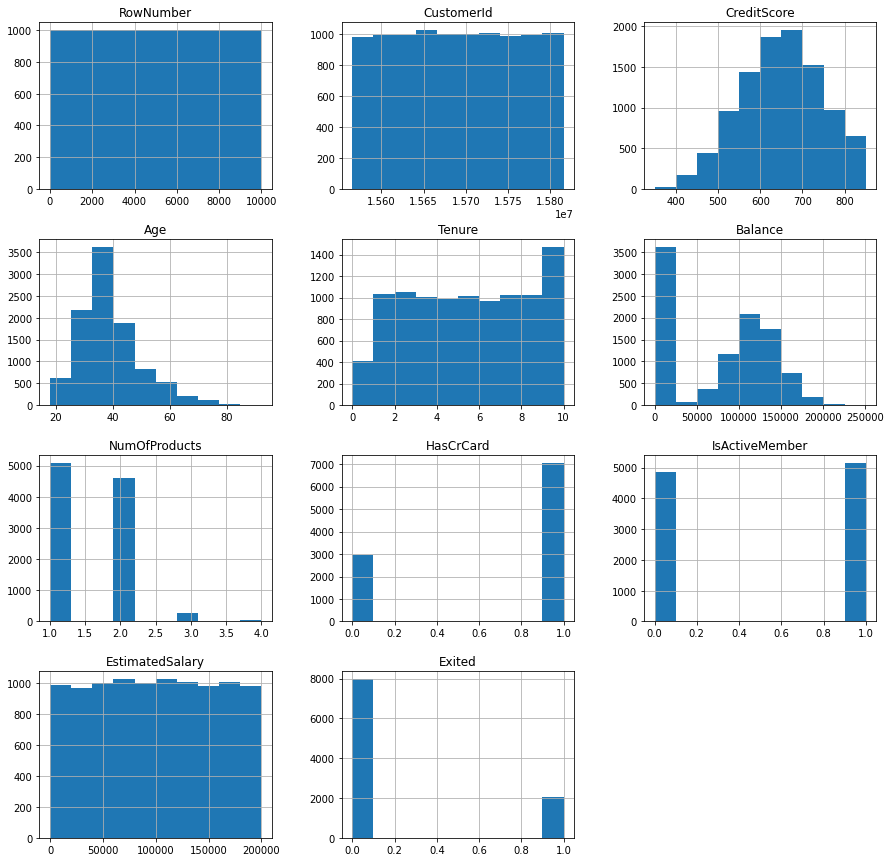

In [10]:
df_data.hist(figsize=[15,15])

<AxesSubplot:>

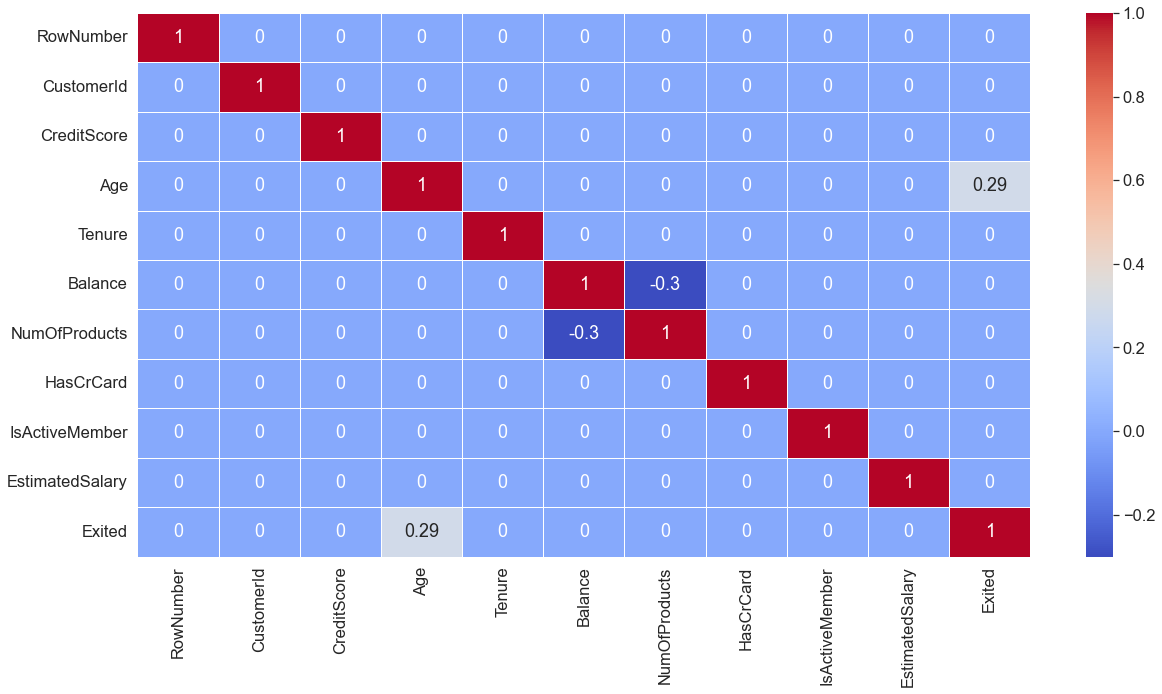

In [11]:
df_data_corr = df_data
df_data_corr = df_data_corr.corr()
df_data_corr = np.round(df_data_corr, 2)
df_data_corr[np.abs(df_data_corr) < 0.2] = 0

plt_figure = plt.figure(figsize=[20,10])
sn.set(font_scale=1.5)
sn.heatmap(data=df_data_corr, annot=True, cmap='coolwarm', linewidth=0.5)

In [12]:
df_data['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

### Exploratory Data Analysis - Выводы:

##### Данные не содержат пропусков и аномалий.
##### Признаки "RowNumber", "CustomerId", "Surname" могут быть исключены, как не несущение полезной информации об анонимном клиенте.
##### Признак "CreditScore" следует нормализовать.
##### Признак "Geography" следует перести в категориальный.
##### Признак "Gender" также следует перевести в категориальный.
##### Признак "Age", согласно описанию набора данных, может отражать линейную зависимость: чем больше возраст клиента, тем менее вероятно, что он покинет банк. Однако матрица корреляций сигнализирует об обратной зависимости: увеличение возраста способствует уходу клиента из банка. Попробую разбить данный признак на интервалы по 10 лет и проанализировать корреляцию с целевой переменной вновь.
##### Признак "Tenure", предварительно, может быть использован в исходном виде: больше лет в банке - меньше вероятность ухода.
##### Признаки "Balance" и "EstimatedSalary" могут быть нормализованы. Однако в целях предотвращения появления отрицательных величин после нормализации, реализую собственную обработку: уменьшу значения в тысячу раз, для понижения размеры данных, и приведу к целочисленному типу.
##### Признак "NumOfProducts" также может быть использован в исходном виде: больше продуктов - меньше вероятность ухода.
##### Признаки "HasCrCard" и "IsActiveMember - категориальные и уже обработаны для ML.
##### Признак "Exited" - целевая переменная, содержит значительный дисбаланс классов. Upsampling может исказить информативность данных, а downsamling - оставит слишком мало данных для обучения и валидации. Сперва попробую компенсировать дисбаланс настройкой модели. Если этого окажется мало, возможно придётся попробовать применить смешанный upsampling и downsamoling.

## Data Preprocessing

In [13]:
df_data_preprocessed = df_data.copy()
df_data_preprocessed = df_data_preprocessed.drop(columns=['RowNumber', 'CustomerId', 'Surname']).copy()
df_data_preprocessed = df_data_preprocessed.drop_duplicates()
df_data_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 937.5+ KB


##### Разобьём данные на два набора: учебный и валидационный.

In [14]:
X = df_data_preprocessed.drop(columns=['Exited']).copy()
y = df_data_preprocessed['Exited'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1, shuffle=True, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 10), (2000, 10), (8000,), (2000,))

### Data Preprocessing Class

In [47]:
class data_preprocessing():
    def __init__(self):
        self.scaler_CreditScore = None
        self.ohe_Geography = None
        self.ohe_Gender = None
        self.ohe_Age = None
    
    def feature_CreditScore(self, df):
#         Нормализация признака "CreditScore".
        if self.scaler_CreditScore is None:
            self.scaler_CreditScore = StandardScaler()
            df['CreditScore'] = self.scaler_CreditScore.fit_transform(df[['CreditScore']])
        else:
            df['CreditScore'] = self.scaler_CreditScore.transform(df[['CreditScore']]).copy()
        return df
    
    def feature_Geography(self, df):
#         Перевод признака "Geography" в категориальный.
        if self.ohe_Geography is None:
            self.ohe_Geography = OneHotEncoder()
            df_Geography = self.ohe_Geography.fit_transform(df[['Geography']])
        else:
            df_Geography = self.ohe_Geography.transform(df[['Geography']])
        df_Geography = pd.DataFrame(df_Geography.toarray(), columns=self.ohe_Geography.categories_[0])
        df_Geography.index = df.index
        
        df = df.join(df_Geography).copy()
        df = df.drop(columns=['Geography'])
        return df
    
    def feature_Gender(self, df):
#         Перевод признака "Gender" в категориальный.
        if self.ohe_Gender is None:
            self.ohe_Gender = OneHotEncoder()
            df_Gender = self.ohe_Gender.fit_transform(df[['Gender']])
        else:
            df_Gender = self.ohe_Gender.transform(df[['Gender']])
        df_Gender = pd.DataFrame(df_Gender.toarray(), columns=self.ohe_Gender.categories_[0])
        df_Gender.index = df.index
        
        df = df.join(df_Gender).copy()
        df = df.drop(columns=['Gender', 'Female']).copy()
        return df
    
    def feature_Age(self, df):
#         Перевод возраста в возрастные группы "Age_p".
        df['Age_p'] = 0
        df.loc[(df['Age'] >= 24) & (df['Age'] <= 30), 'Age_p'] = 1
        df.loc[(df['Age'] >= 31) & (df['Age'] <= 40), 'Age_p'] = 2
        df.loc[(df['Age'] >= 41) & (df['Age'] <= 50), 'Age_p'] = 3
        df.loc[(df['Age'] >= 51) & (df['Age'] <= 60), 'Age_p'] = 4
        df.loc[(df['Age'] >= 61) & (df['Age'] <= 70), 'Age_p'] = 5
        df.loc[(df['Age'] >= 71), 'Age_p'] = 6
        df = df.drop(columns=['Age']).copy()
        
#         Перевод признака "Age_p" в категориальный, так как каждая группа может иметь собственное влияние.
        if self.ohe_Age is None:
            self.ohe_Age = OneHotEncoder()
            df_Age = self.ohe_Age.fit_transform(df[['Age_p']])
        else:
            df_Age = self.ohe_Age.transform(df[['Age_p']])
        df_Age = pd.DataFrame(df_Age.toarray(), columns=self.ohe_Age.categories_[0])
        df_Age.index = df.index
        df_Age = df_Age.add_prefix('Age_')
        
        df = df.join(df_Age).copy()
        df = df.drop(columns=['Age_p']).copy()
        return df
    
    def feature_Balance(self, df):
#         Сжатие признака "Balance".
        df['Balance'] = np.round(df['Balance'] / 1000, 0).astype(int)
        return df
    
    def feature_EstimatedSalary(self, df):
#         Сжатие признака "EstimatedSalary".
        df['EstimatedSalary'] = np.round(df['EstimatedSalary'] / 1000, 0).astype(int)
        return df
        
    def fit(self, df):
#         Метод первичной обработки обучающего набора данных.
        df = self.feature_CreditScore(df)
        df = self.feature_Geography(df)
        df = self.feature_Gender(df)
        df = self.feature_Age(df)
        df = self.feature_Balance(df)
        df = self.feature_EstimatedSalary(df)
        return df
    
    def transform(self, df):
#         Метод вторичной обработки валидационного набора данных.
        df = self.feature_CreditScore(df)
        df = self.feature_Geography(df)
        df = self.feature_Gender(df)
        df = self.feature_Age(df)
        df = self.feature_Balance(df)
        df = self.feature_EstimatedSalary(df)
        return df

##### Выполним предобработку наборов данных.

In [41]:
dp = data_preprocessing()
X_train_p = dp.fit(X_train)
X_test_p = dp.transform(X_test)

In [42]:
X_train_p.head()

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Male,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6
4256,-0.556600,9,134,1,1,1,13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9151,-0.370472,1,0,2,1,0,192,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
696,-2.118010,1,64,1,1,1,77,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4898,-1.094304,7,0,1,0,1,161,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6427,0.994469,2,0,2,1,0,143,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [43]:
X_test_p.head()

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Male,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6
4466,-2.448905,2,0,2,1,1,61,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3754,-1.187368,8,119,1,1,1,136,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9601,0.094849,7,90,1,1,0,137,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9758,-0.970218,4,126,1,1,1,75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8577,1.077193,1,136,1,1,1,122,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [44]:
X_train_p = reduce_memory_usage(X_train_p)
X_train_p.info()

Initial memory usage of dataframe:	1.35 Mb
Final memory usage of dataframe:	0.74 Mb
Memory usage has been decreased by:	45.19 %
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 4256 to 8407
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      8000 non-null   float32
 1   Tenure           8000 non-null   int8   
 2   Balance          8000 non-null   int16  
 3   NumOfProducts    8000 non-null   int8   
 4   HasCrCard        8000 non-null   int8   
 5   IsActiveMember   8000 non-null   int8   
 6   EstimatedSalary  8000 non-null   int16  
 7   France           8000 non-null   float32
 8   Germany          8000 non-null   float32
 9   Spain            8000 non-null   float32
 10  Male             8000 non-null   float32
 11  Age_0            8000 non-null   float32
 12  Age_1            8000 non-null   float32
 13  Age_2            8000 non-null   float32
 14  Age_3            8000

In [45]:
X_test_p = reduce_memory_usage(X_test_p)
X_test_p.info()

Initial memory usage of dataframe:	0.338 Mb
Final memory usage of dataframe:	0.185 Mb
Memory usage has been decreased by:	45.187 %
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 4466 to 8350
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      2000 non-null   float32
 1   Tenure           2000 non-null   int8   
 2   Balance          2000 non-null   int16  
 3   NumOfProducts    2000 non-null   int8   
 4   HasCrCard        2000 non-null   int8   
 5   IsActiveMember   2000 non-null   int8   
 6   EstimatedSalary  2000 non-null   int16  
 7   France           2000 non-null   float32
 8   Germany          2000 non-null   float32
 9   Spain            2000 non-null   float32
 10  Male             2000 non-null   float32
 11  Age_0            2000 non-null   float32
 12  Age_1            2000 non-null   float32
 13  Age_2            2000 non-null   float32
 14  Age_3            2

## Model Building

##### С помощью GridSearchCV выполним эксперимент с перебором кучи параметров, чтобы понять, какие сочетания дают лучшую метрику.

In [62]:
%%time

paramns = {'penalty': ['l1', 'l2', 'elasticnet'],
           'C': np.arange(0, 1.1, 0.1),
           'class_weight': ['balanced', {0: y_train.value_counts(normalize=True)[1], 1: y_train.value_counts(normalize=True)[0]}],
           'solver': ['lbfgs', 'saga'],
           'max_iter': [1000]}

gs = GridSearchCV(estimator=LogisticRegression(),
                 param_grid=paramns,
                 scoring='f1',
                 n_jobs=-1)

gs.fit(X_train_p, y_train)
y_pred = gs.predict(X_test_p)
print(classification_report(y_test, y_pred))

c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
350 fits failed out of a total of 660.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\users\sergeyz06\appdata\loc

              precision    recall  f1-score   support

           0       0.91      0.74      0.81      1593
           1       0.41      0.71      0.52       407

    accuracy                           0.73      2000
   macro avg       0.66      0.72      0.66      2000
weighted avg       0.81      0.73      0.75      2000

Wall time: 44.2 s


c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


##### За 44 секунды определён победитель:

In [63]:
gs.best_estimator_

LogisticRegression(C=0.4, class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='saga')

##### Попробуем разнообразить веса классов, чтобы лучше обработать дисбаланс классов.

In [65]:
%%time

paramns = {'penalty': ['l1', 'l2', 'elasticnet'],
           'C': np.arange(0.3, 0.8, 0.1),
           'class_weight': ['balanced', {0: 0.15, 1: 0.85}, {0: 0.16, 1: 0.84}, {0: 0.17, 1: 0.83}, {0: 0.18, 1: 0.82}, {0: 0.19, 1: 0.81}, {0: 0.20, 1: 0.80}, {0: 0.21, 1: 0.79}, {0: 0.22, 1: 0.78}, {0: 0.23, 1: 0.77}, {0: 0.24, 1: 0.76}, {0: 0.25, 1: 0.75}],
           'solver': ['saga'],
           'max_iter': [1000]}

gs = GridSearchCV(estimator=LogisticRegression(),
                 param_grid=paramns,
                 scoring='f1',
                 n_jobs=-1)

gs.fit(X_train_p, y_train)
y_pred = gs.predict(X_test_p)
print(classification_report(y_test, y_pred))

c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1471, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.war

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1593
           1       0.46      0.62      0.53       407

    accuracy                           0.77      2000
   macro avg       0.67      0.72      0.69      2000
weighted avg       0.80      0.77      0.78      2000

Wall time: 1min 54s


c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


##### За чуть менее чем 2 минуты GridSearchCV показала, что лучший f1 = 0.77 оказался на границе весов признаков:

In [66]:
gs.best_estimator_

LogisticRegression(C=0.3, class_weight={0: 0.25, 1: 0.75}, max_iter=1000,
                   solver='saga')

##### Попробуем ещё чуть расширить диапазон весов классов:

In [67]:
%%time

paramns = {'penalty': ['l1', 'l2', 'elasticnet'],
           'C': np.arange(0, 1.1, 0.1),
           'class_weight': [{0: 0.25, 1: 0.75}, {0: 0.26, 1: 0.74}, {0: 0.27, 1: 0.73}, {0: 0.28, 1: 0.72}, {0: 0.29, 1: 0.71}, {0: 0.30, 1: 0.70}],
           'solver': ['saga'],
           'max_iter': [1000],
           'l1_ratio': np.arange(0, 1.1, 0.1)}

gs = GridSearchCV(estimator=LogisticRegression(),
                 param_grid=paramns,
                 scoring='f1',
                 n_jobs=-1)

gs.fit(X_train_p, y_train)
y_pred = gs.predict(X_test_p)
print(classification_report(y_test, y_pred))

c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
660 fits failed out of a total of 10890.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
660 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1589, in fit
    fold_coefs_ = Parallel(
  File "c:\users\sergeyz06\appdata\local\programs\python\python39\lib\sit

              precision    recall  f1-score   support

           0       0.89      0.80      0.85      1593
           1       0.45      0.62      0.52       407

    accuracy                           0.77      2000
   macro avg       0.67      0.71      0.68      2000
weighted avg       0.80      0.77      0.78      2000

Wall time: 31min 27s


c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


##### За чуть более чем пол часа перебора параметров получился сопоставимый результат, f1 = 0.77.

In [68]:
gs.best_estimator_

LogisticRegression(C=0.1, class_weight={0: 0.25, 1: 0.75}, l1_ratio=0.5,
                   max_iter=1000, penalty='elasticnet', solver='saga')

### Upsampling

In [74]:
upsampling_counts = y_train.value_counts()[0] - y_train.value_counts()[1]
upsampling_counts

4740

##### Столько значений нужно добавить, чтобы устранить дисбаланс классов.

In [85]:
X_train_p_us = X_train_p[y_train == 1].sample(n = upsampling_counts, replace=True, random_state=1).copy()
X_train_p_us = pd.concat([X_train_p, X_train_p_us]).reset_index(drop=True).copy()
X_train_p_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12740 entries, 0 to 12739
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      12740 non-null  float32
 1   Tenure           12740 non-null  int8   
 2   Balance          12740 non-null  int16  
 3   NumOfProducts    12740 non-null  int8   
 4   HasCrCard        12740 non-null  int8   
 5   IsActiveMember   12740 non-null  int8   
 6   EstimatedSalary  12740 non-null  int16  
 7   France           12740 non-null  float32
 8   Germany          12740 non-null  float32
 9   Spain            12740 non-null  float32
 10  Male             12740 non-null  float32
 11  Age_0            12740 non-null  float32
 12  Age_1            12740 non-null  float32
 13  Age_2            12740 non-null  float32
 14  Age_3            12740 non-null  float32
 15  Age_4            12740 non-null  float32
 16  Age_5            12740 non-null  float32
 17  Age_6       

In [86]:
y_train_us = y_train[y_train == 1].sample(n = upsampling_counts, replace=True, random_state=1).copy()
y_train_us = pd.concat([y_train, y_train_us]).reset_index(drop=True).copy()
y_train_us.value_counts()

0    6370
1    6370
Name: Exited, dtype: int64

##### Попробуем обучить модель на новых данных.

In [87]:
%%time

paramns = {'penalty': ['l1', 'l2', 'elasticnet'],
           'C': np.arange(0, 1.1, 0.1),
           'solver': ['saga'],
           'max_iter': [1000],
           'l1_ratio': np.arange(0, 1.1, 0.1)}

gs = GridSearchCV(estimator=LogisticRegression(),
                 param_grid=paramns,
                 scoring='f1',
                 n_jobs=-1)

gs.fit(X_train_p_us, y_train_us)
y_pred = gs.predict(X_test_p)
print(classification_report(y_test, y_pred))

c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
110 fits failed out of a total of 1815.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1589, in fit
    fold_coefs_ = Parallel(
  File "c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1593
           1       0.40      0.71      0.52       407

    accuracy                           0.73      2000
   macro avg       0.66      0.72      0.66      2000
weighted avg       0.81      0.73      0.75      2000

Wall time: 8min 23s


c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [88]:
gs.best_estimator_

LogisticRegression(C=0.1, l1_ratio=0.0, max_iter=1000, solver='saga')

##### Несмотря на наличие дублей при upsampling'е, модель продемонстрировала не на много худшую метрику, f1 = 0.73. Однако Precision для дифицитного класса всё же пострадала.

### Downsampling

In [89]:
downsampling_counts = y_train.value_counts()[1]
downsampling_counts

1630

##### Столько значений каждого класса должно быть для устранения дисбаланса классов.

In [91]:
X_train_p_ds = X_train_p[y_train == 0].sample(n=downsampling_counts, replace=False, random_state=1).copy()
X_train_p_ds = pd.concat([X_train_p_ds, X_train_p[y_train == 1]]).reset_index(drop=True).copy()
X_train_p_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3260 entries, 0 to 3259
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      3260 non-null   float32
 1   Tenure           3260 non-null   int8   
 2   Balance          3260 non-null   int16  
 3   NumOfProducts    3260 non-null   int8   
 4   HasCrCard        3260 non-null   int8   
 5   IsActiveMember   3260 non-null   int8   
 6   EstimatedSalary  3260 non-null   int16  
 7   France           3260 non-null   float32
 8   Germany          3260 non-null   float32
 9   Spain            3260 non-null   float32
 10  Male             3260 non-null   float32
 11  Age_0            3260 non-null   float32
 12  Age_1            3260 non-null   float32
 13  Age_2            3260 non-null   float32
 14  Age_3            3260 non-null   float32
 15  Age_4            3260 non-null   float32
 16  Age_5            3260 non-null   float32
 17  Age_6         

In [93]:
y_train_ds = y_train[y_train == 0].sample(n=downsampling_counts, random_state=1).copy()
y_train_ds = pd.concat([y_train_ds, y_train[y_train == 1]]).reset_index(drop=True).copy()
y_train_ds.value_counts()

0    1630
1    1630
Name: Exited, dtype: int64

##### Также попробуем обучить модель на новых данных.

In [94]:
%%time

paramns = {'penalty': ['l1', 'l2', 'elasticnet'],
           'C': np.arange(0, 1.1, 0.1),
           'solver': ['saga'],
           'max_iter': [1000],
           'l1_ratio': np.arange(0, 1.1, 0.1)}

gs = GridSearchCV(estimator=LogisticRegression(),
                 param_grid=paramns,
                 scoring='f1',
                 n_jobs=-1)

gs.fit(X_train_p_ds, y_train_ds)
y_pred = gs.predict(X_test_p)
print(classification_report(y_test, y_pred))

c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
110 fits failed out of a total of 1815.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1589, in fit
    fold_coefs_ = Parallel(
  File "c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1593
           1       0.40      0.71      0.51       407

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.66      2000
weighted avg       0.80      0.72      0.75      2000

Wall time: 2min 5s


c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [95]:
gs.best_estimator_

LogisticRegression(C=0.6000000000000001, l1_ratio=0.5, max_iter=1000,
                   penalty='elasticnet', solver='saga')

##### Модель показала ещё чуть-чуть худшие резульататы, f1 = 0.72.

### Sampling - Выводы:

##### Первоначальное предположение подтвердилось: модель с параметром class_weight показала наилучшие результаты, f1 = 0.77.
##### Модели, работавшие с upsampling и downsampling, показали f1 = 0.73 и 0.72 соответственно.
##### ИМХО, повторно убеждаюсь, что лучше использовать инструменты, разработанные умными людьми для решения конкретных проблем. Так как в данном случае учтены многие тонкости, которые самому руками реализовать не хватит знаний и сил.